In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
import gc 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.utils import class_weight
import numpy as np

#pyarrow for parquet

2025-12-23 14:09:02.412670: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-23 14:09:02.412858: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 14:09:02.439935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-23 14:09:02.969683: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
gm = pd.read_parquet('gm64.parquet')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)
print(gm.shape)
print(gm.dtypes)

(10961229, 63)
protocol_0           float32
protocol_6           float32
protocol_17          float32
flow_duration        float32
flow_byts_s          float32
flow_pkts_s          float32
fwd_pkts_s           float32
bwd_pkts_s           float32
tot_fwd_pkts         float32
tot_bwd_pkts         float32
totlen_fwd_pkts      float32
totlen_bwd_pkts      float32
fwd_pkt_len_max      float32
fwd_pkt_len_min      float32
fwd_pkt_len_mean     float32
fwd_pkt_len_std      float32
bwd_pkt_len_max      float32
bwd_pkt_len_min      float32
bwd_pkt_len_mean     float32
bwd_pkt_len_std      float32
pkt_len_max          float32
pkt_len_min          float32
pkt_len_mean         float32
pkt_len_std          float32
pkt_len_var          float32
fwd_seg_size_min     float32
fwd_act_data_pkts    float32
flow_iat_mean        float32
flow_iat_max         float32
flow_iat_min         float32
flow_iat_std         float32
fwd_iat_tot          float32
fwd_iat_max          float32
fwd_iat_min          float32

In [4]:
print("separating label...")
y = gm.pop('Label') 
X = gm 
del gm 

gc.collect()
print("separation done")

separating label...
separation done


In [5]:
#split data 80:20 for train and temp
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.20,
    stratify = y,
    random_state = 42,
    shuffle = True # shuffle code
)

In [6]:
# #split temp 1:1 for validation and test
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp,
#     test_size = 0.50,
#     stratify = y_temp,
#     random_state = 42,
#     shuffle = True
# )

In [7]:
#log transform (dont run twice)
X_train_scaled= np.log1p(X_train)
# x_val = np.log1p(X_val)
X_test_scaled = np.log1p(X_test)
print('log transform done')

log transform done


In [8]:
#standardscaler (Standardization (Z-Score): )
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)
print("standardscaler done")

joblib.dump(X_train_scaled, 'X_train_scaledpca.joblib')
joblib.dump(X_test_scaled, 'X_test_scaledpca.joblib')

standardscaler done


['X_test_scaledpca.joblib']

In [9]:
joblib.dump(scaler, 'scaler_brainpca.joblib')
print("Step 1 Done: Scaler saved!")

Step 1 Done: Scaler saved!


In [10]:
#pca
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("pca done")

pca done


In [11]:
joblib.dump(pca, 'pca_brain.joblib')
print("Step 1 Done: PCA saved!")

Step 1 Done: PCA saved!


In [12]:
Classifier_accuracy = []

In [13]:
import joblib
try:
    feature_names = joblib.load('model_column_names3.joblib')
    print('ok')
except:
    # Fallback if file missing
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns.tolist()
        print('okok')
    else:
        feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]
        print('okai')

ok


In [14]:
print("--- Training Logistic Regression ---")
start = time.time()

# Initialize
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=4)

# Train
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

end = time.time()
print(f"Training Time: {(end - start)/60:.2f} minutes")

# Report
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

# Save
joblib.dump(lr_model, 'models/lrpca.joblib')
print("Logistic Regression Saved.")

--- Training Logistic Regression ---
Training Time: 3.45 minutes
Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.81      0.54      0.65    876898
           1       0.75      0.92      0.82   1315348

    accuracy                           0.77   2192246
   macro avg       0.78      0.73      0.74   2192246
weighted avg       0.77      0.77      0.76   2192246

Logistic Regression Saved.


--- Training Decision Tree ---
Training Time: 5.80 minutes
Decision Tree Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    876898
           1       1.00      1.00      1.00   1315348

    accuracy                           1.00   2192246
   macro avg       1.00      1.00      1.00   2192246
weighted avg       1.00      1.00      1.00   2192246

Decision Tree Saved.
Generating Tree Graph...


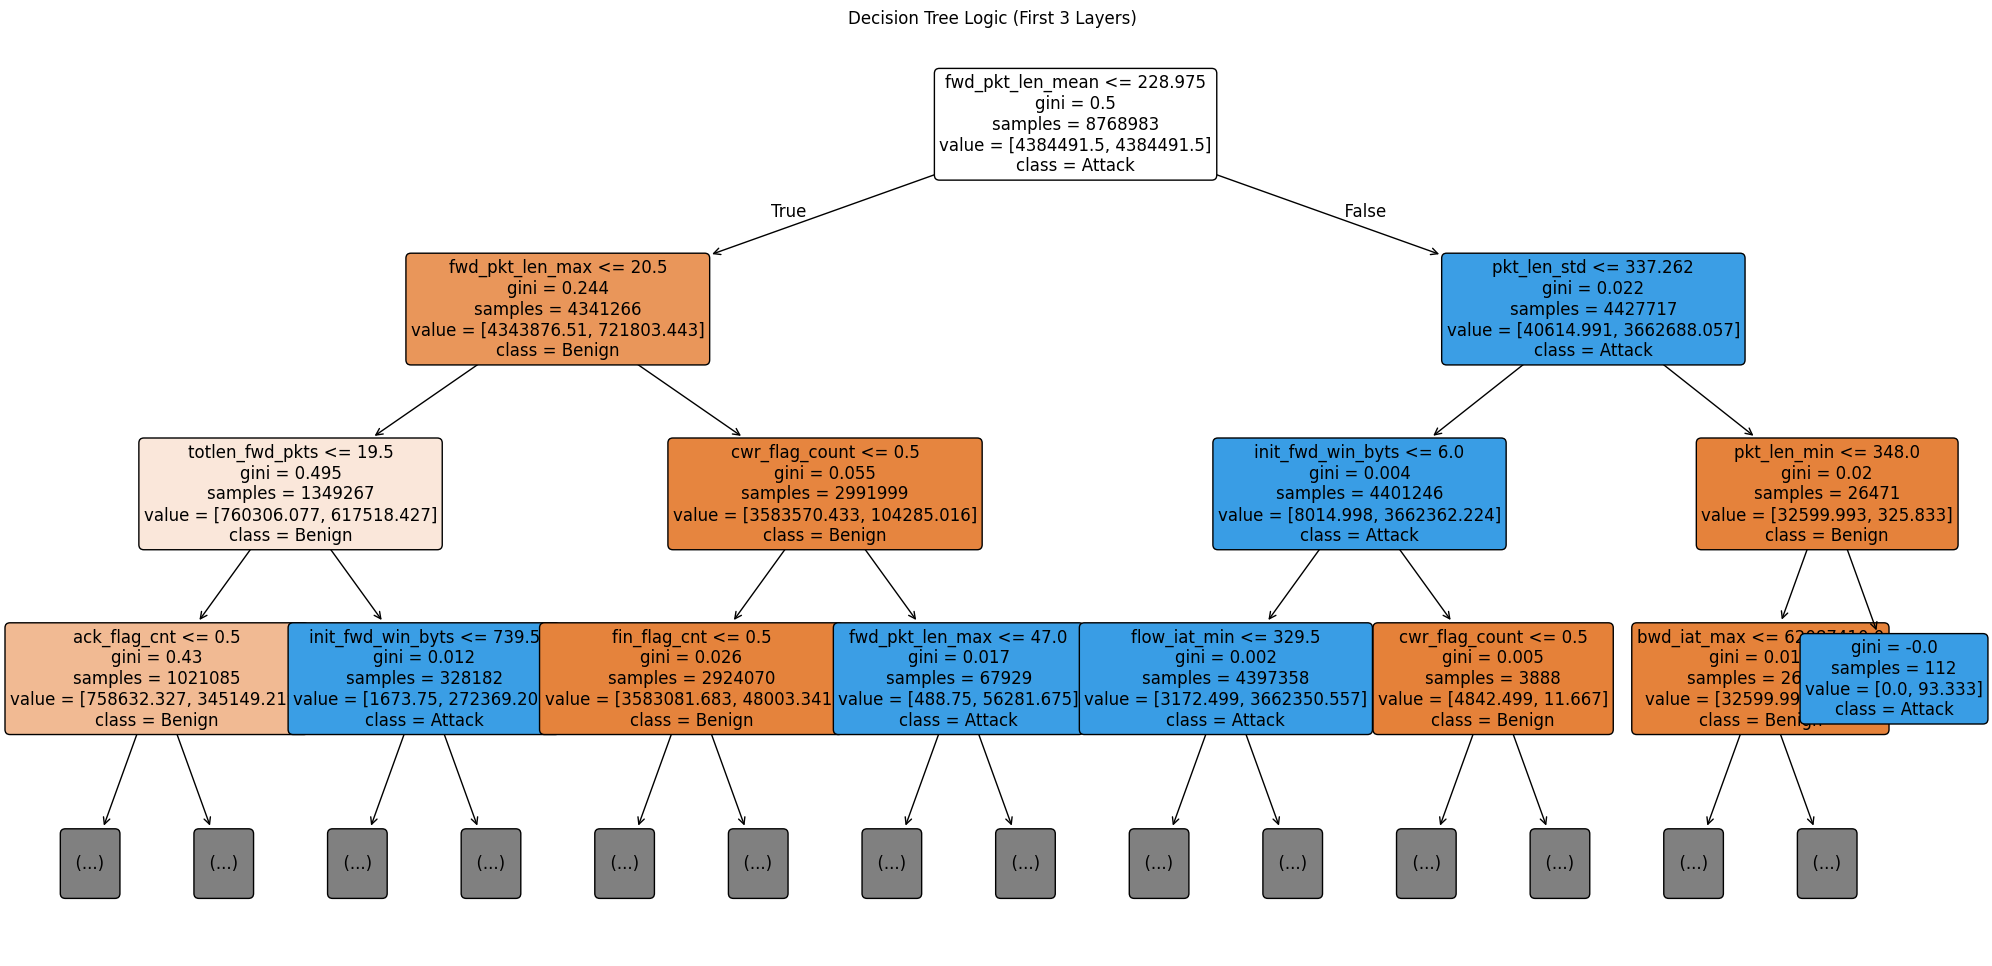

In [15]:
print("--- Training Decision Tree ---")
start = time.time()

# Initialize
dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=20)

# Train
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

end = time.time()
print(f"Training Time: {(end - start)/60:.2f} minutes")

# Report
print("Decision Tree Results:")
print(classification_report(y_test, y_pred_dt))

# Save
joblib.dump(dt_model, 'models/dtpca.joblib')
print("Decision Tree Saved.")

# --- VISUALIZATION: PLOT THE TREE ---
print("Generating Tree Graph...")
plt.figure(figsize=(25, 12))
plot_tree(dt_model, 
          max_depth=3,              # Only show top 3 levels so it's readable
          feature_names=feature_names,
          class_names=['Benign', 'Attack'],
          filled=True, 
          rounded=True,
          fontsize=12)
plt.title("Decision Tree Logic (First 3 Layers)")
plt.show()
plt.close()

--- Training Random Forest ---
Training Time: 9.82 minutes
Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    876898
           1       1.00      1.00      1.00   1315348

    accuracy                           1.00   2192246
   macro avg       1.00      1.00      1.00   2192246
weighted avg       1.00      1.00      1.00   2192246

Random Forest Saved.


/tmp/ipykernel_2021622/936047054.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices[:top_n]], y=[feature_names[i] for i in indices[:top_n]], palette="viridis")


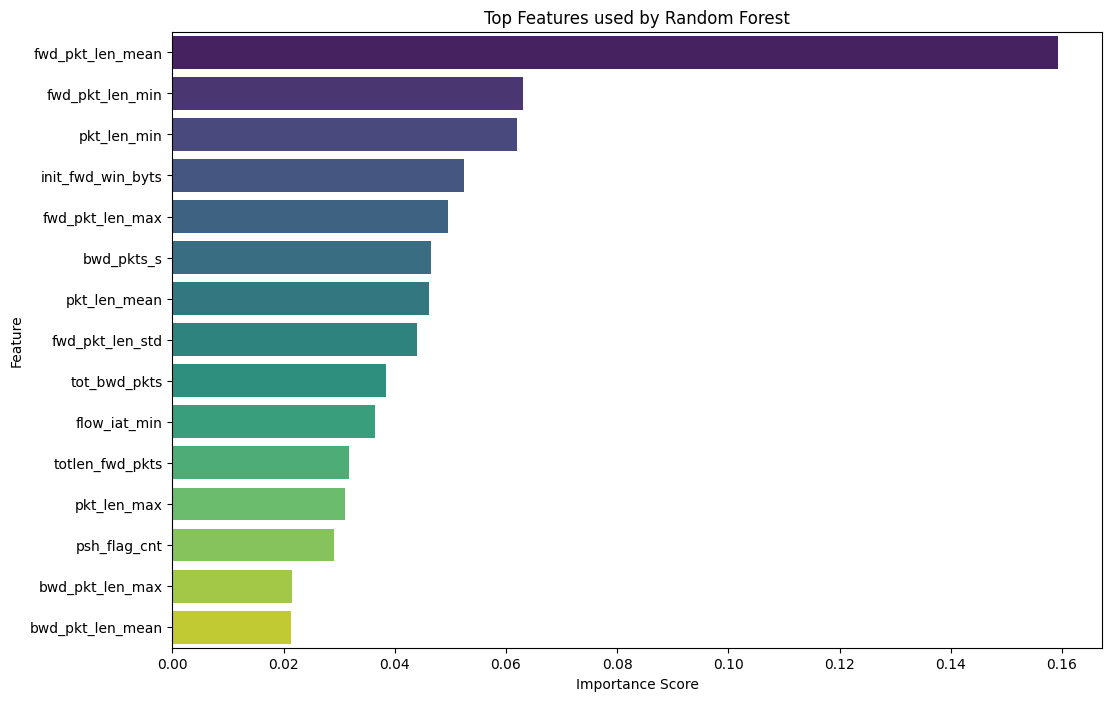

In [16]:
print("--- Training Random Forest ---")
start = time.time()

# Initialize
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=20, n_jobs=4)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

end = time.time()
print(f"Training Time: {(end - start)/60:.2f} minutes")

# Report
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

# Save
joblib.dump(rf_model, 'models/rfpca.joblib')
print("Random Forest Saved.")

# --- VISUALIZATION: FEATURE IMPORTANCE ---
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15 # Show top 15 features

plt.figure(figsize=(12, 8))
plt.title("Top Features used by Random Forest")
sns.barplot(x=importances[indices[:top_n]], y=[feature_names[i] for i in indices[:top_n]], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
plt.close()

In [17]:
#TRAINING KNN AND SVC

###

In [18]:
# make big dataset into subsets
# X_train_small = X_train_scaled[:100000]
# y_train_small = y_train[:100000]

print("--- Creating Subsets for Slow Models ---")

# 1. KNN Subset (40k rows)
X_knn, _, y_knn, _ = train_test_split(
    X_train_pca, y_train,
    train_size=40_000,
    stratify=y_train,
    random_state=42
)
print(f"KNN Data: {X_knn.shape}, Labels: {y_knn.shape}")

# 2. SVM Subset (120k rows)
X_svm, _, y_svm, _ = train_test_split(
    X_train_pca, y_train,
    train_size=120_000,
    stratify=y_train,
    random_state=42
)
print(f"SVM Data: {X_svm.shape}, Labels: {y_svm.shape}")

# 3. DNN Subset (300k rows)
X_dnn, _, y_dnn, _ = train_test_split(
    X_train_pca, y_train,
    train_size=300_000,
    stratify=y_train,
    random_state=42
)
print(f"DNN Data: {X_dnn.shape}, Labels: {y_dnn.shape}")

cores = 6

--- Creating Subsets for Slow Models ---
KNN Data: (40000, 18), Labels: (40000,)
SVM Data: (120000, 18), Labels: (120000,)
DNN Data: (300000, 18), Labels: (300000,)


In [19]:

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=cores)

print(f"--- Training knn (On Subset) ---")
start = time.time()

# training on small data
knn.fit(X_knn, y_knn)

print("Predicting... (This part might be slow for KNN)")
y_pred = knn.predict(X_test_pca)

end = time.time()
print(f"Time: {(end - start)/60:.2f} minutes")
print(classification_report(y_test, y_pred))
joblib.dump(knn, 'knn_scaledpca.joblib')
print("KNN model saved!")

--- Training knn (On Subset) ---
Predicting... (This part might be slow for KNN)
Time: 0.32 minutes
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    876898
           1       1.00      1.00      1.00   1315348

    accuracy                           1.00   2192246
   macro avg       1.00      1.00      1.00   2192246
weighted avg       1.00      1.00      1.00   2192246

KNN model saved!


In [20]:
svm = SVC(class_weight='balanced', kernel='rbf', cache_size=2000)

print(f"--- Training svm (On Subset) ---")
start = time.time()

# training on small data
svm.fit(X_svm, y_svm)

print("Predicting... (This part might be slow for SVM)")
y_pred = svm.predict(X_test_pca)

end = time.time()
print(f"Time: {(end - start)/60:.2f} minutes")
print(classification_report(y_test, y_pred))
joblib.dump(svm, 'svm_scaledpca.joblib')
print("SVM model saved!")

--- Training svm (On Subset) ---
Predicting... (This part might be slow for SVM)
Time: 2.49 minutes
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    876898
           1       1.00      0.99      0.99   1315348

    accuracy                           0.99   2192246
   macro avg       0.99      0.99      0.99   2192246
weighted avg       0.99      0.99      0.99   2192246

SVM model saved!


In [21]:
#TRAINING DNN

###

In [22]:
# 1. Weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_dnn),
    y=y_dnn
)
dnn_weights = {0: weights[0], 1: weights[1]}

# 2. Build Model
dnn = keras.Sequential([
    # This was the broken line. It should look exactly like this:
    layers.InputLayer(shape=(X_dnn.shape[1],)), 
    
    layers.Dense(128, activation='relu'), 
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation='sigmoid')
])

dnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

# 3. Train
print("--- Training DNN on SCALED Data ---")
history = dnn.fit(
    X_dnn, y_dnn,
    validation_data=(X_test_pca, y_test),
    epochs=10,
    batch_size=2048, 
    class_weight=dnn_weights,
    verbose=1
)

# 4. Evaluate
y_pred_probs = dnn.predict(X_test_pca)
y_pred_dnn = (y_pred_probs > 0.5).astype("int32")
print(classification_report(y_test, y_pred_dnn))

# 5. Save
dnn.save('dnn_scaledpca.keras')
print("Step 5 Done: Deep Learning model saved!")

--- Training DNN on SCALED Data ---
Epoch 1/10


E0000 00:00:1766471485.251482 2021622 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1766471485.256964 2021622 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9401 - loss: 0.1504 - val_accuracy: 0.9891 - val_loss: 0.0471
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9827 - loss: 0.0509 - val_accuracy: 0.9904 - val_loss: 0.0336
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9874 - loss: 0.0380 - val_accuracy: 0.9916 - val_loss: 0.0258
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9897 - loss: 0.0310 - val_accuracy: 0.9929 - val_loss: 0.0218
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9914 - loss: 0.0261 - val_accuracy: 0.9933 - val_loss: 0.0195
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9921 - loss: 0.0234 - val_accuracy: 0.9932 - val_loss: 0.0182
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9926 - loss: 0.0214 - val_accuracy: 0.9936 - val_loss: 0.0177
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9931 - loss: 0.0199 - val_accuracy: 0.9939 - val_

In [23]:
temp_df = pd.read_parquet('gm50.parquet')
cols = temp_df.drop(columns=['Label']).columns.tolist()

joblib.dump(cols, 'model_column_namespca.joblib')
print(f"Saved {len(cols)} column names for live deployment.")

Saved 62 column names for live deployment.


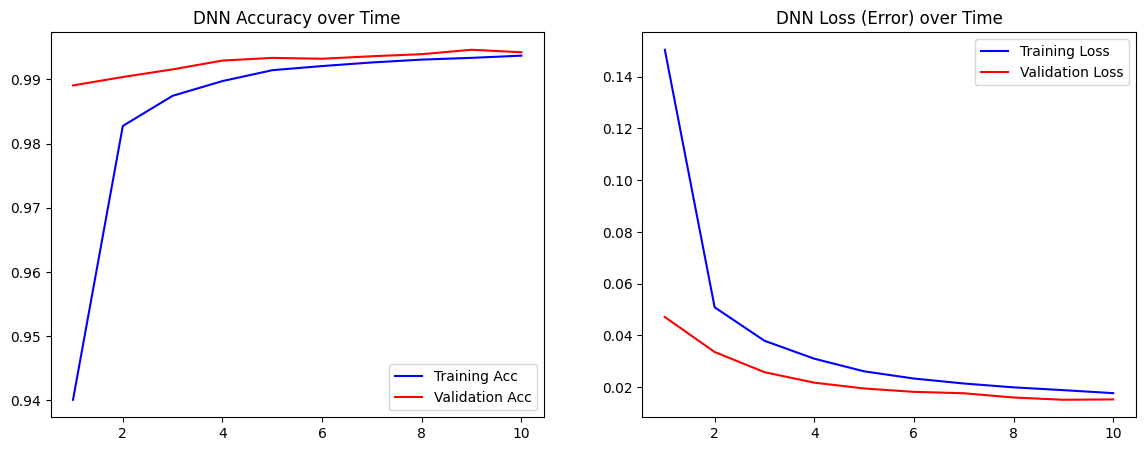

In [24]:
if 'history' in locals():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.title('DNN Accuracy over Time')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('DNN Loss (Error) over Time')
    plt.legend()

    plt.show()
    plt.close()

In [25]:
subset_size = 100000

# Raw Subset (For Trees)
X_test_viz = X_test[:subset_size]
y_test_viz = y_test[:subset_size]

# Scaled Subset (For Distance Models)
X_test_pca = X_test_pca[:subset_size]

Calculating scores on 100000 rows (Speed Mode)...
Scoring Random Forest...
Scoring Decision Tree...
Scoring Logistic Regression...
Scoring KNN...
Scoring SVM...
Scoring DNN...


/tmp/ipykernel_2021622/2602355903.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=list(sorted_scores.keys()), y=list(sorted_scores.values()), palette="viridis")


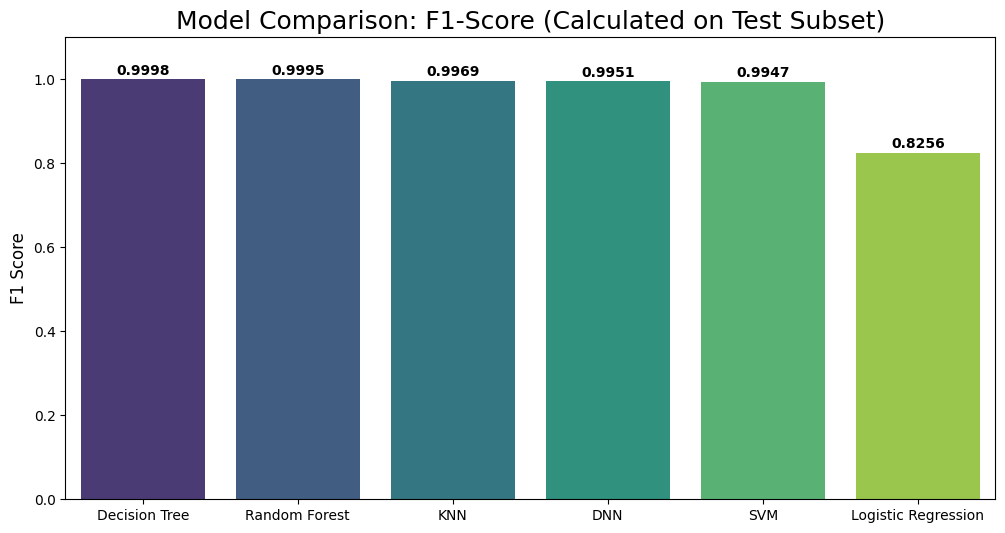

In [26]:
model_scores = {}
print(f"Calculating scores on {subset_size} rows (Speed Mode)...")

# GROUP A: Trees & Linear (Raw Data Subset)
print("Scoring Random Forest...")
y_pred_rf = rf_model.predict(X_test_viz)
model_scores['Random Forest'] = f1_score(y_test_viz, y_pred_rf)

print("Scoring Decision Tree...")
y_pred_dt = dt_model.predict(X_test_viz)
model_scores['Decision Tree'] = f1_score(y_test_viz, y_pred_dt)

print("Scoring Logistic Regression...")
y_pred_lr = lr_model.predict(X_test_viz)
model_scores['Logistic Regression'] = f1_score(y_test_viz, y_pred_lr)

# GROUP B: Distance/Scaled Models (Scaled Data Subset)
print("Scoring KNN...")
y_pred_knn = knn.predict(X_test_pca)
model_scores['KNN'] = f1_score(y_test_viz, y_pred_knn)

print("Scoring SVM...")
y_pred_svm = svm.predict(X_test_pca)
model_scores['SVM'] = f1_score(y_test_viz, y_pred_svm)

# GROUP C: Deep Learning (Scaled Data Subset)
print("Scoring DNN...")
y_probs_dnn = dnn.predict(X_test_pca, verbose=0)
y_pred_dnn = (y_probs_dnn > 0.5).astype("int32")
model_scores['DNN'] = f1_score(y_test_viz, y_pred_dnn)


# --- 2. GENERATE THE MASTER GRAPH ---
sorted_scores = dict(sorted(model_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=list(sorted_scores.keys()), y=list(sorted_scores.values()), palette="viridis")

# Add numbers on top
for i, v in enumerate(sorted_scores.values()):
    barplot.text(i, v + 0.01, f"{v:.4f}", ha='center', color='black', fontweight='bold')

plt.ylim(0.0, 1.1)
plt.title("Model Comparison: F1-Score (Calculated on Test Subset)", fontsize=18)
plt.ylabel("F1 Score", fontsize=12)
plt.show()
plt.close()

Generating CM for Random Forest...
Generating CM for Decision Tree...
Generating CM for Logistic Reg...
Generating CM for KNN...
Generating CM for SVM...
Generating CM for DNN...


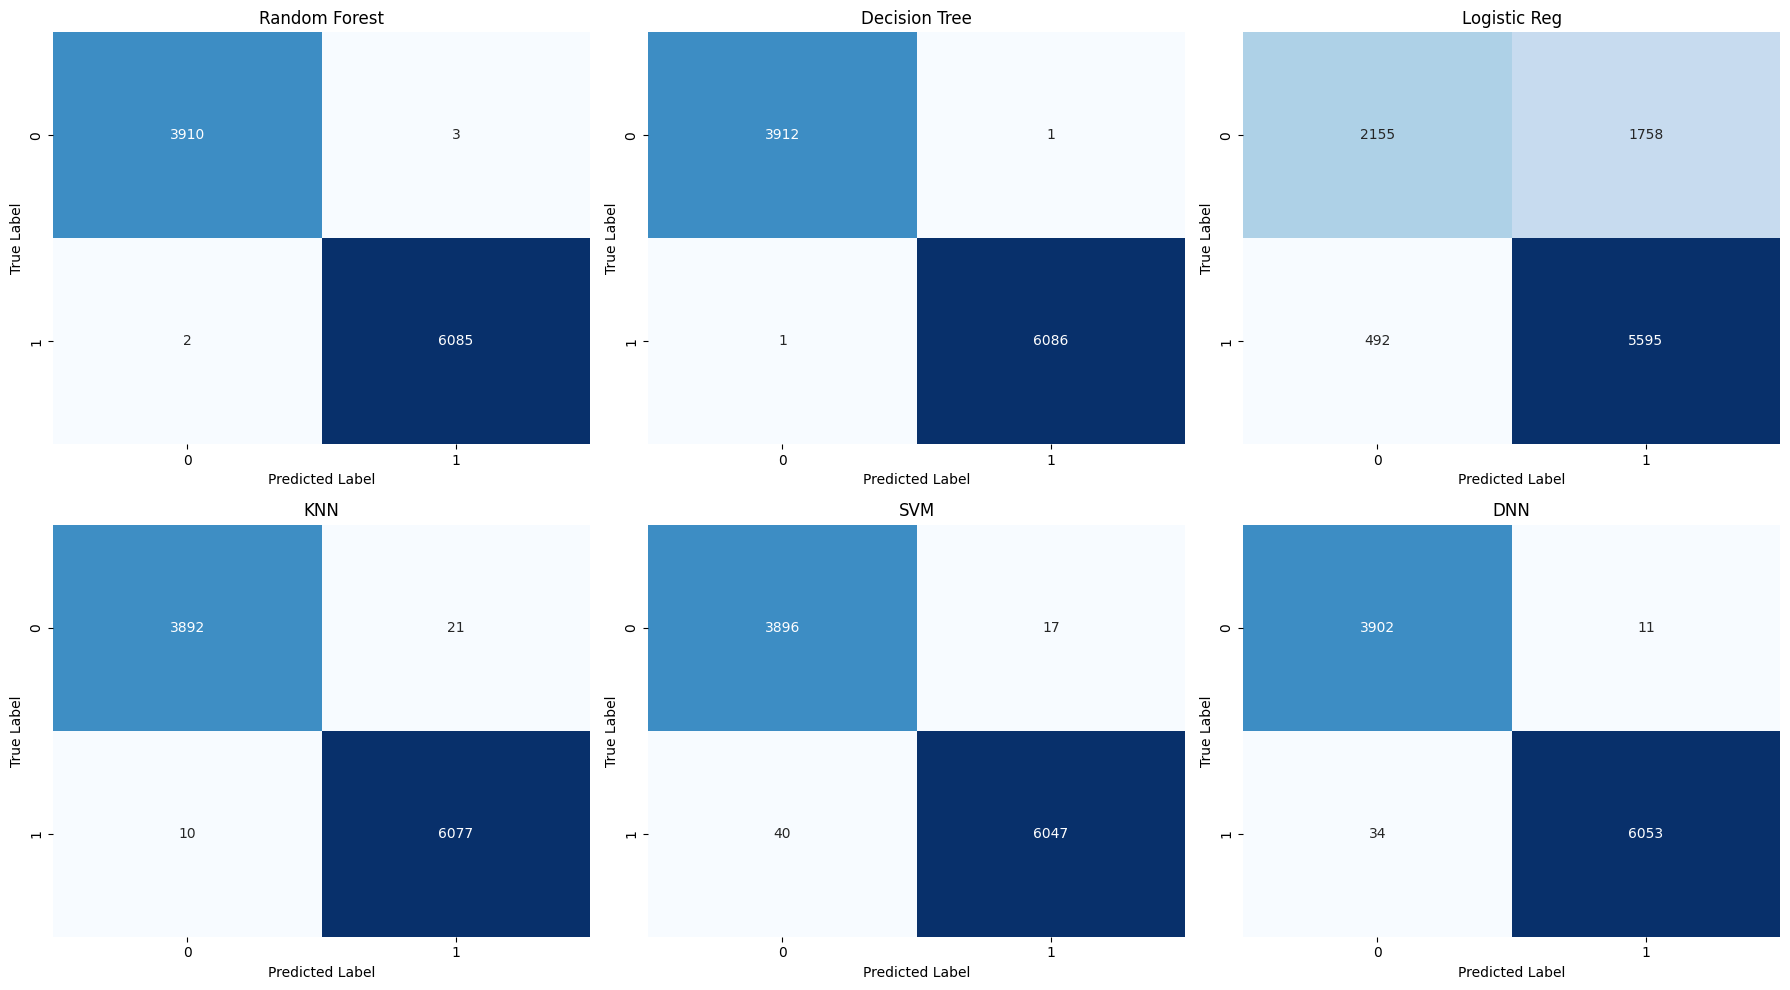

In [27]:
def plot_confusion_matrices(models_dict, X_raw, X_scaled, y_true):
    n_models = len(models_dict)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, (name, (model, use_scaled, is_dnn)) in enumerate(models_dict.items()):
        if i >= len(axes): break
        
        # Select Data
        X_data = X_scaled if use_scaled else X_raw
        
        # Predict
        print(f"Generating CM for {name}...")
        if is_dnn:
            # Handle Keras Probabilities
            preds = (model.predict(X_data, verbose=0) > 0.5).astype("int32")
        else:
            # Handle Scikit-Learn
            preds = model.predict(X_data)
            
        cm = confusion_matrix(y_true, preds)
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(name)
        axes[i].set_ylabel('True Label')
        axes[i].set_xlabel('Predicted Label')
        
    plt.tight_layout()
    plt.show()
    plt.close()

# --- USAGE ---
# Format: (Model_Variable, Use_Scaled_Data, Is_Deep_Learning)
model_registry = {
    "Random Forest": (rf_model, False, False),
    "Decision Tree": (dt_model, False, False),
    "Logistic Reg":  (lr_model, False, False),
    "KNN":           (knn, True, False),
    "SVM":           (svm, True, False),
    "DNN":           (dnn, True, True)  # <--- True here triggers the probability logic
}

plot_confusion_matrices(model_registry, X_test[:10000], X_test_pca[:10000], y_test[:10000])